In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import os
import warnings

warnings.filterwarnings('ignore')
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"
%matplotlib inline


In [2]:
# Load the dataset (ICD-9 diagnosis codes for each hospital admission)
DIAGNOSES_ICD = pd.read_csv('DIAGNOSES_ICD.csv.gz')

# Preview the dataset
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [3]:

# Step 3: Info and missing values
DIAGNOSES_ICD.info()
print(DIAGNOSES_ICD.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB
ROW_ID         0
SUBJECT_ID     0
HADM_ID        0
SEQ_NUM       47
ICD9_CODE     47
dtype: int64


In [4]:
DIAGNOSES_ICD.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM
count,651047.000000,651047.000000,651047.000000,651000.000000
mean,325524.000000,38971.159758,150017.744819,7.913836
std,187941.224689,29372.198841,28878.068648,6.072633
min,1.000000,2.000000,100001.000000,1.000000
25%,162762.500000,14562.500000,125028.000000,3.000000
50%,325524.000000,28671.000000,150140.000000,6.000000
75%,488285.500000,63715.000000,174978.000000,11.000000
max,651047.000000,99999.000000,199999.000000,39.000000


In [5]:
DIAGNOSES_ICD['SEQ_NUM'].fillna(-1, inplace=True)  #
DIAGNOSES_ICD['ICD9_CODE'].fillna('UNKNOWN', inplace=True) 

In [6]:
# Check duplicates
duplicates = DIAGNOSES_ICD.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')

# Drop duplicates if necessary
DIAGNOSES_ICD.drop_duplicates(inplace=True)


Total duplicate rows: 0


In [7]:
# Encode categorical data into numeric format
DIAGNOSES_ICD['ICD9_CODE_CAT'] = DIAGNOSES_ICD['ICD9_CODE'].astype('category').cat.codes

# Check changes
DIAGNOSES_ICD[['ICD9_CODE', 'ICD9_CODE_CAT']].head()

,ICD9_CODE,ICD9_CODE_CAT
0,40301,1970
1,486,2451
2,58281,2943
3,5855,2963
4,4254,2072


In [8]:
#  Save cleaned version

# Keep ICD9_CODE_CAT for downstream use
diagnoses_cleaned = DIAGNOSES_ICD.copy() 
diagnoses_cleaned.to_csv('diagnoses_icd_cleaned.csv', index=False)


In [9]:
!pip install sdv

In [10]:
# Imports
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata



In [11]:
diagnoses_icd_cleaned = diagnoses_cleaned.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE'])
diagnoses_icd_cleaned.head()

,ROW_ID,SEQ_NUM,ICD9_CODE_CAT
0,1297,1.0,1970
1,1298,2.0,2451
2,1299,3.0,2943
3,1300,4.0,2963
4,1301,5.0,2072


In [12]:


#  Generate metadata for SINGLE TABLE
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(diagnoses_icd_cleaned)

#  Initialize synthesizer (no enforce_minimal in this version)
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=30
)

#  Fit the synthesizer to the data
synthesizer.fit(diagnoses_icd_cleaned)

#  Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)

#  Save synthetic data
synthetic_data.to_csv("synthetic_diagnoses_icd.csv", index=False)

#  Preview
synthetic_data.head()

,ROW_ID,SEQ_NUM,ICD9_CODE_CAT
0,611396,13.0,1626
1,997597,1.0,262
2,12719465,2.0,3000
3,3129255,3.0,2090
4,8813810,12.0,2147


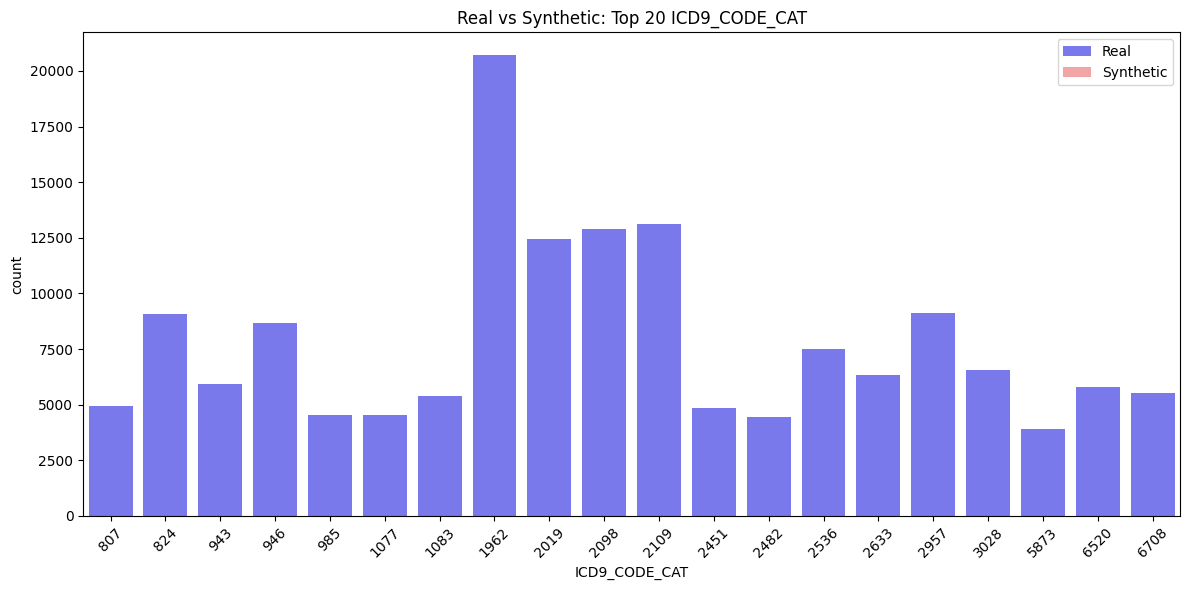

In [13]:
# Plot top 20 most frequent ICD9_CODE_CAT values
top_n = 20
top_categories = diagnoses_icd_cleaned['ICD9_CODE_CAT'].value_counts().nlargest(top_n).index

# Filter both datasets
filtered_real = diagnoses_icd_cleaned[diagnoses_icd_cleaned['ICD9_CODE_CAT'].isin(top_categories)]
filtered_syn = synthetic_data[synthetic_data['ICD9_CODE_CAT'].isin(top_categories)]

plt.figure(figsize=(12, 6))
sns.countplot(x='ICD9_CODE_CAT', data=filtered_real, color='blue', label='Real', alpha=0.6)
sns.countplot(x='ICD9_CODE_CAT', data=filtered_syn, color='red', label='Synthetic', alpha=0.4)
plt.legend()
plt.title("Real vs Synthetic: Top 20 ICD9_CODE_CAT")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [14]:
#  Optional model - predict if diagnosis is high or low based on SEQ_NUM
features = ['SEQ_NUM', 'ICD9_CODE_CAT']
diagnoses_cleaned['target'] = (diagnoses_cleaned['SEQ_NUM'] > diagnoses_cleaned['SEQ_NUM'].median()).astype(int)
synthetic_data['target'] = (synthetic_data['SEQ_NUM'] > diagnoses_cleaned['SEQ_NUM'].median()).astype(int)

for col in features:
    diagnoses_cleaned[col] = diagnoses_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

X_real = diagnoses_cleaned[features]
y_real = diagnoses_cleaned['target']
X_syn = synthetic_data[features]
y_syn = synthetic_data['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"\nModel accuracy on real DIAGNOSES_ICD:     {real_acc:.2f}")
print(f"Model accuracy on synthetic DIAGNOSES_ICD: {syn_acc:.2f}")



Model accuracy on real DIAGNOSES_ICD:     1.00
Model accuracy on synthetic DIAGNOSES_ICD: 1.00


In [15]:
#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=30  # Same as CTGAN for fair comparison
)

#  Fit the VAE synthesizer
vae_synthesizer.fit(diagnoses_icd_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_diagnoses_icd_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

,ROW_ID,SEQ_NUM,ICD9_CODE_CAT
0,611396,7.0,6959
1,997597,11.0,924
2,12719465,5.0,988
3,3129255,3.0,5888
4,8813810,15.0,4104


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 1: Define features (ensure these exist in both real and synthetic)
features = ['SEQ_NUM', 'ICD9_CODE_CAT']

# Step 2: Use median from real data to create binary classification target
median_seq = diagnoses_cleaned['SEQ_NUM'].median()

# Step 3: Add target column to real and VAE synthetic data
diagnoses_cleaned['target'] = (diagnoses_cleaned['SEQ_NUM'] > median_seq).astype(int)
synthetic_data_vae['target'] = (synthetic_data_vae['SEQ_NUM'] > median_seq).astype(int)

# Step 4: Encode features if not already encoded
for col in features:
    diagnoses_cleaned[col] = diagnoses_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Step 5: Split real and synthetic data
X_real = diagnoses_cleaned[features]
y_real = diagnoses_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Step 6: Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Step 7: Print comparison
print(f"Model accuracy on REAL DIAGNOSES_ICD data:       {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC DIAGNOSES_ICD:   {vae_acc:.2f}")


Model accuracy on REAL DIAGNOSES_ICD data:       1.00
Model accuracy on VAE SYNTHETIC DIAGNOSES_ICD:   1.00


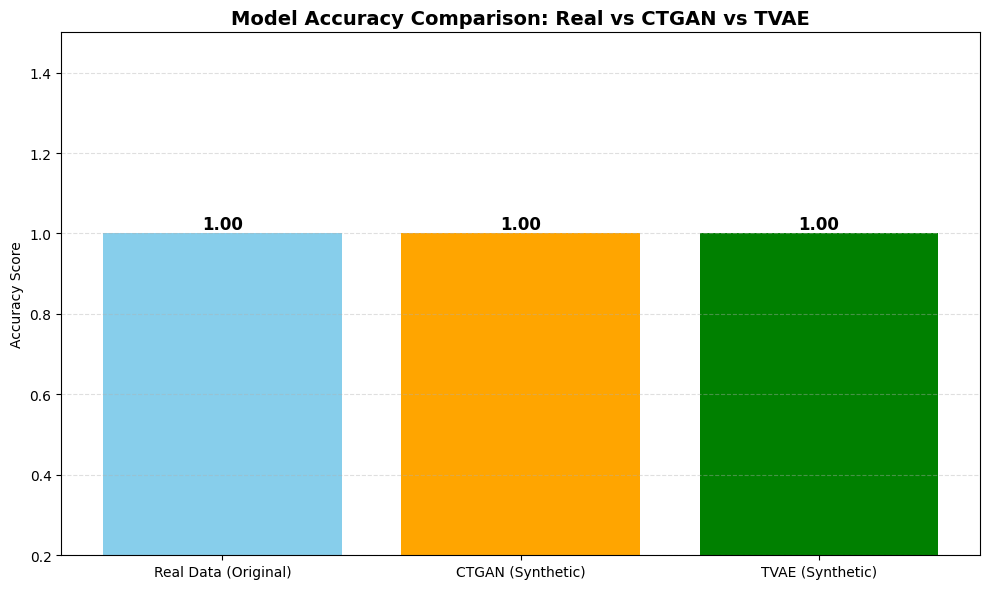

In [19]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
